# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1. Define the model class.

In [3]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(no_hidden, no_labels),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Sigmoid()
        )

    # YOUR CODE HERE
    def forward(self, x):
        return self.mlp_stack(x)
    

#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

1. Split the dataset and do preprocessing.

In [10]:
from common_utils import split_dataset, preprocess_dataset


def preprocess(df):
    # YOUR CODE HERE
    #print(df.columns) #we have filename and label col we wanna drop
    X_train, y_train, X_test, y_test = split_dataset(df, ["filename", "label"], 0.3, 0)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()
X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)



0        neg
1        neg
2        neg
3        neg
4        neg
        ... 
12052    pos
12053    pos
12054    pos
12055    pos
12056    pos
Name: label, Length: 12057, dtype: object


#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [5]:
class CustomDataset(Dataset): #we use dataloaders as we are doing mini batch gradient descent
    # YOUR CODE HERE
    def __init__(self, X, y):
        self.X =torch.tensor(X, dtype=torch.float)
        self.y =torch.tensor(y, dtype=torch.float).unsqueeze(1) #convert y to a column vector
    
    def __len__(self): #magic method
        return len(self.y)

    def __getitem__(self,idx): #magic method
        return self.X[idx], self.y[idx]


def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # YOUR CODE HERE
    train_data = CustomDataset(X_train_scaled, y_train)
    test_data = CustomDataset(X_test_scaled, y_test)
    train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True)
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

2. Next, define the model, optimizer and loss function.

In [6]:
# YOUR CODE HERE
model = MLP(X_train_scaled.shape[1], 128, 1) #no of features, no of hidden units, no of labels
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #lr is learning rate
loss_fn = nn.BCELoss() #binary cross entropy loss

model

MLP(
  (mlp_stack): Sequential(
    (0): Linear(in_features=77, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Sigmoid()
  )
)

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [7]:
# YOUR CODE HERE
#from eg5.1a
from common_utils import EarlyStopper

def train_loop(dataloader, model, loss_fn, optimizer): #from eg5.4a (classification of MINST images with ealy stopping, I had to edit to fit binary classification )
    size = len(dataloader.dataset) #total number of examples in dataset
    num_batches = len(dataloader) #total number of batches in dataloader (so batch size of our mini batch gd)
    train_loss, correct = 0, 0
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X) #making predictions using model
        loss = loss_fn(pred, y) #computing loss by comparing predictions to actual label

        # print("loss is", loss) #loss is tensor(0.6170, grad_fn=<BinaryCrossEntropyBackward0>)
        
        train_loss += loss.item() #this gets the value from above line 0.6170

        correct += ((pred > 0.5).eq(y)).type(torch.float).sum().item() #instead of using pred.argmax(1), just use pred > 0.5 as we are doing binary classification

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    train_loss /= num_batches #get avg loss over all batches
    correct /= size #get accuracy as total correct over total examples
    return train_loss, correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += ((pred > 0.5).eq(y)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size

    return test_loss, correct



early_stopper = EarlyStopper(patience=3)
epochs = 100

train_loss, test_loss = [], []
train_correct, test_correct = [], []
for t in range(epochs):
    tr_loss, tr_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(tr_loss), train_correct.append(tr_correct)
    
    t_loss, t_correct = test_loop(test_dataloader, model, loss_fn)
    test_loss.append(t_loss), test_correct.append(t_correct)

    print(f"Epoch {t+1}: Train_accuracy: {(100*tr_correct):>0.2f}%, Train_loss: {tr_loss:>8f}, Test_accuracy: {(100*t_correct):>0.2f}%, Test_loss: {t_loss:>8f}")

    if early_stopper.early_stop(t_loss): 
        print(f"Early Stop at epoch {t+1}")
        break

print("Done!")

Epoch 1: Train_accuracy: 50.57%, Train_loss: 0.691409, Test_accuracy: 53.92%, Test_loss: 0.687162
Epoch 2: Train_accuracy: 53.34%, Train_loss: 0.686243, Test_accuracy: 54.89%, Test_loss: 0.682084
Epoch 3: Train_accuracy: 56.00%, Train_loss: 0.679989, Test_accuracy: 56.27%, Test_loss: 0.680055
Epoch 4: Train_accuracy: 56.80%, Train_loss: 0.676031, Test_accuracy: 55.78%, Test_loss: 0.677296
Epoch 5: Train_accuracy: 58.31%, Train_loss: 0.670142, Test_accuracy: 58.35%, Test_loss: 0.677884
Epoch 6: Train_accuracy: 59.07%, Train_loss: 0.666381, Test_accuracy: 57.90%, Test_loss: 0.673795
Epoch 7: Train_accuracy: 59.37%, Train_loss: 0.659865, Test_accuracy: 58.02%, Test_loss: 0.679557
Epoch 8: Train_accuracy: 59.34%, Train_loss: 0.660596, Test_accuracy: 58.73%, Test_loss: 0.670000
Epoch 9: Train_accuracy: 61.16%, Train_loss: 0.656003, Test_accuracy: 58.93%, Test_loss: 0.668079
Epoch 10: Train_accuracy: 60.98%, Train_loss: 0.652166, Test_accuracy: 58.26%, Test_loss: 0.673960
Epoch 11: Train_acc

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


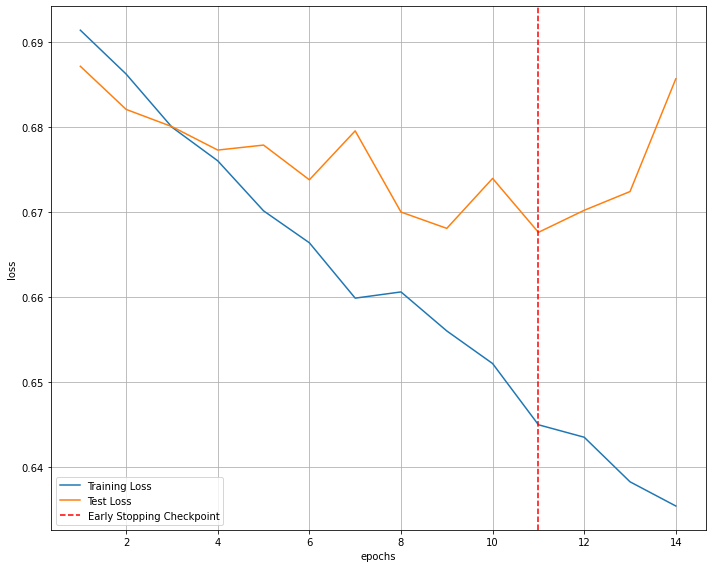

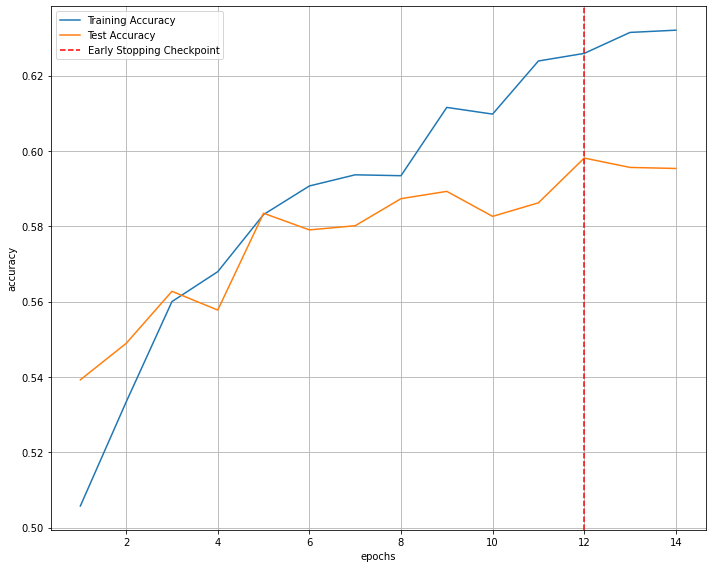

In [8]:
# YOUR CODE HERE
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(test_loss)+1),test_loss,label='Test Loss')

# find position of lowest validation loss
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# plot learning curves
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_correct)+1),train_correct, label='Training Accuracy')
plt.plot(range(1,len(test_correct)+1),test_correct,label='Test Accuracy')

# find position of highest test correct
minposs = test_correct.index(max(test_correct))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


2. Comment on line plots.

In [9]:
# YOUR CODE HERE
answer = "The model is overfitting towards the end. At epoch 11 to epoch 14, the training loss goes down, but the test loss goes up instead. At epoch 12 to epoch 14, the test accuracy also goes down, while the training accuracy goes up. These occurances are a sign of overfitting."